In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import math
from itertools import product
import numpy as np

In [48]:
df = pd.read_csv("/content/HSG Historical Data.csv", parse_dates=['Date'], index_col='Date', sep=';')
df = df.sort_index(ascending=True)
print(df.head())

            Price   Open   High    Low    Vol. Change %
Date                                                   
2019-03-01  6.100  5.897  6.100  5.772  11.57M    6,77%
2019-03-04  6.526  6.421  6.526  6.231  14.78M    6,99%
2019-03-05  6.500  6.559  6.822  6.402  16.02M   -0,40%
2019-03-06  6.277  6.474  6.559  6.107  15.89M   -3,43%
2019-03-07  6.034  6.238  6.277  6.034   9.73M   -3,87%


In [49]:
print(df.dtypes)

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object


In [50]:
df['Vol.'] = df['Vol.'].apply(lambda x: float(x.replace('M', '').replace('K', '')) * (1e6 if 'M' in x else 1e3))

df['Change %'] = df['Change %'].str.replace('%', '')
df['Change %'] = df['Change %'].str.replace(',', '.').astype(float) / 100
df.dropna(inplace=True)

print(df.dtypes)
df.head()

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,6.100,5.897,6.100,5.772,11570000.0,0.0677
2019-03-04,6.526,6.421,6.526,6.231,14780000.0,0.0699
2019-03-05,6.500,6.559,6.822,6.402,16020000.0,-0.0040
2019-03-06,6.277,6.474,6.559,6.107,15890000.0,-0.0343
2019-03-07,6.034,6.238,6.277,6.034,9730000.0,-0.0387


Ma trận tương quan:
             Price      Open      High       Low      Vol.  Change %
Price     1.000000  0.998459  0.999345  0.999274  0.307800  0.008212
Open      0.998459  1.000000  0.999437  0.999410  0.303800 -0.035226
High      0.999345  0.999437  1.000000  0.999326  0.312638 -0.017039
Low       0.999274  0.999410  0.999326  1.000000  0.298190 -0.016454
Vol.      0.307800  0.303800  0.312638  0.298190  1.000000  0.072918
Change %  0.008212 -0.035226 -0.017039 -0.016454  0.072918  1.000000


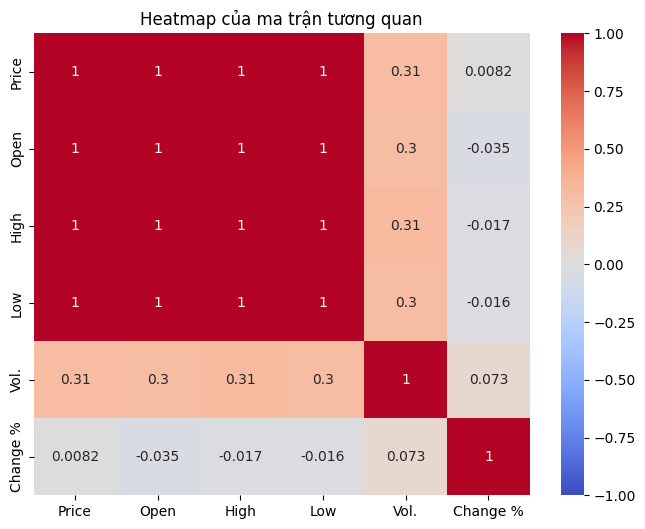

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame(df)

corr_matrix = data.corr()

print("Ma trận tương quan:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap của ma trận tương quan')
plt.show()

In [52]:
df = df[["Price", "Open", "High", "Low"]]
df.head()

,Price,Open,High,Low
Date,,,,
2019-03-01,6.100,5.897,6.100,5.772
2019-03-04,6.526,6.421,6.526,6.231
2019-03-05,6.500,6.559,6.822,6.402
2019-03-06,6.277,6.474,6.559,6.107
2019-03-07,6.034,6.238,6.277,6.034


In [53]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
train_df = train
train = np.asarray(train)

print(len(df))
print(len(train))
print(len(test))

1252
1001
251


In [54]:
#Find best AR and MA for VARMA modeling by evalute AIC.
p_values = range(1, 5)
q_values = range(1, 5)

best_aic = np.inf
best_order = (0, 0)

for p in p_values:
    for q in q_values:
        try:
            model = VARMAX(data, order=(p, q))
            model_fit = model.fit(disp=False)

            aic = model_fit.aic

            print(f'VARMA({p}, {q}) - AIC: {aic}')

            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
        except Exception as e:
            print(f'VARMA({p}, {q}) - Error: {e}')

print(f'Best VARMA order: {best_order} - AIC: {best_aic}')

VARMA(1, 1) - Error: 5-th leading minor of the array is not positive definite
VARMA(1, 2) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.4504e-29): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.20017e-27): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimat

VARMA(1, 3) - Error: Schur decomposition solver error.
VARMA(1, 4) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.4504e-29): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/

VARMA(2, 1) - AIC: 36812.06105212601
VARMA(2, 2) - Error: 5-th leading minor of the array is not positive definite
VARMA(2, 3) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecas

VARMA(2, 4) - Error: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.4143e-23): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA(3, 1) - AIC: 112248.20027252997
VARMA(3, 2) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecas

VARMA(3, 3) - AIC: 42725103685.478775


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VARMA(3, 4) - Error: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.5593e-24): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA(4, 1) - AIC: 36318.437140022856


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VARMA(4, 2) - AIC: 2028637.213972224


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMA(4, 3) - AIC: 67538751.25912485
VARMA(4, 4) - Error: 5-th leading minor of the array is not positive definite
Best VARMA order: (4, 1) - AIC: 36318.437140022856


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [55]:
model = VARMAX(train, order=(4, 1))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                              Statespace Model Results                              
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                 1001
Model:                           VARMA(4,1)   Log Likelihood                -246.011
                                + intercept   AIC                            680.022
Date:                      Sun, 09 Jun 2024   BIC                           1141.445
Time:                              13:03:59   HQIC                           855.386
Sample:                                   0                                         
                                     - 1001                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):         0.00, 0.00, 0.00, 0.00   Jarque-Bera (JB):   306.80, 1302.05, 850.36, 609.96
Prob(Q):                    0.98, 0.97, 0.98, 0.99   Prob(JB):                    0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H): 1

In [56]:
forecast = model_fit.forecast(steps=len(test))

forecast = pd.DataFrame(forecast, index=test.index, columns=test.columns)

print(forecast.head())

                Price       Open       High        Low
Date                                                  
2023-03-02  15.702498  15.752639  16.074289  15.491486
2023-03-03  15.755123  15.693260  16.062985  15.431299
2023-03-06  15.684317  15.752148  16.107044  15.360715
2023-03-07  15.692411  15.694641  16.107570  15.345116
2023-03-08  15.706808  15.716232  16.069853  15.386039


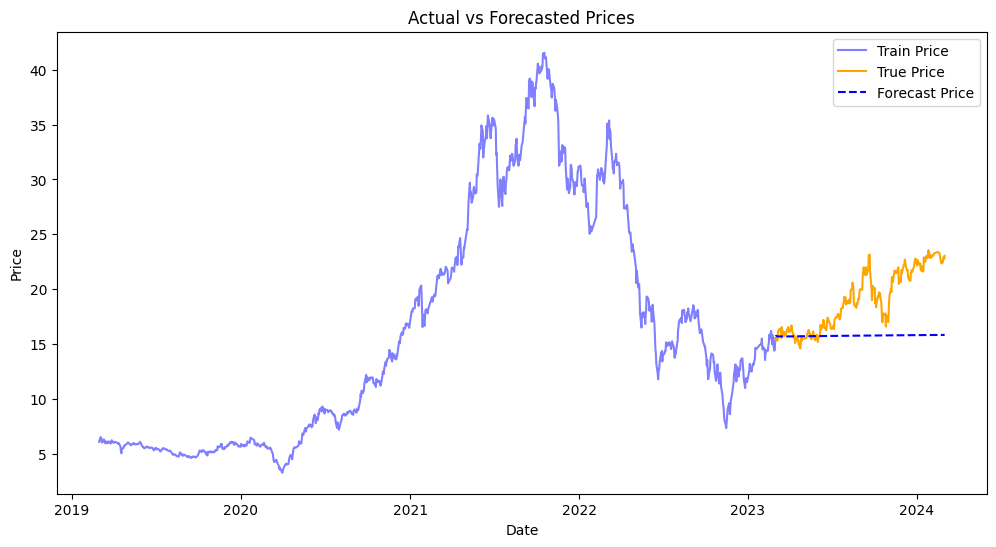

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)

plt.plot(test.index, test["Price"], label='True Price', color='orange')

plt.plot(test.index, forecast["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

mae = mean_absolute_error(test["Price"], forecast["Price"])
mape = mean_absolute_percentage_error(test["Price"], forecast["Price"])
rmse = np.sqrt(mean_squared_error(test["Price"], forecast["Price"]))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 3.2998658572852015
Mean Absolute Percentage Error (MAPE): 0.15809722391264855
Root Mean Squared Error (RMSE): 4.179345599776236


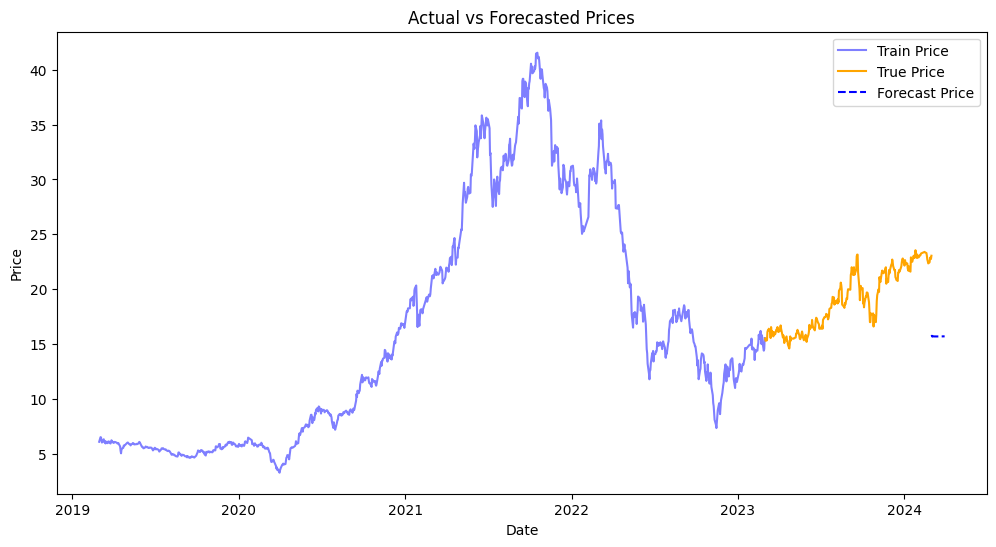

In [59]:
forecast_horizon = 30
next_30_days_forecast = model_fit.forecast(steps=forecast_horizon)

# Create a dataframe for the forecasted values
# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(next_30_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)
# Plot the forecasted values
plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)
plt.plot(test.index, test["Price"], label='True Price', color='orange')
plt.plot(forecast_df.index, forecast_df["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

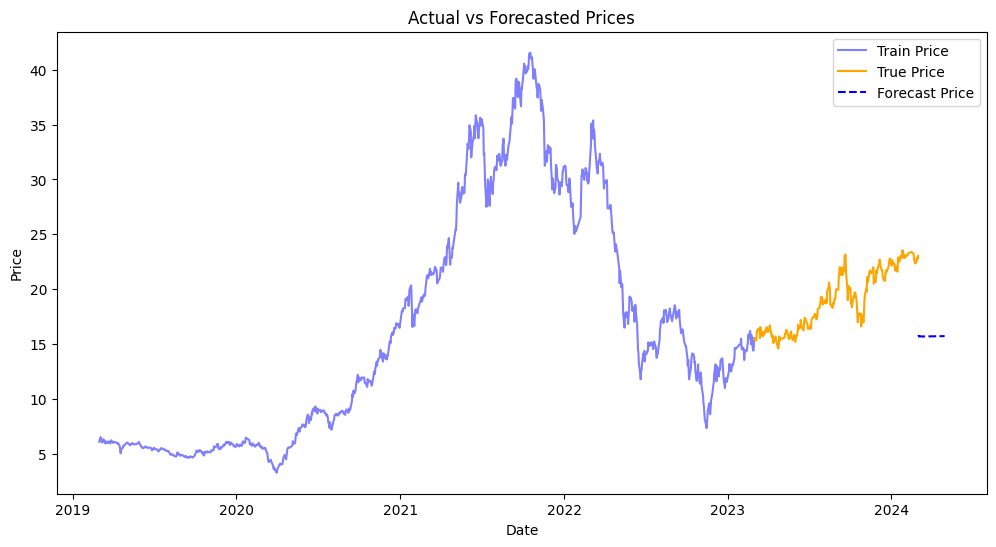

In [60]:
forecast_horizon = 60
next_60_days_forecast = model_fit.forecast(steps=forecast_horizon)

# Create a dataframe for the forecasted values
# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(next_60_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)
# Plot the forecasted values
plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)
plt.plot(test.index, test["Price"], label='True Price', color='orange')
plt.plot(forecast_df.index, forecast_df["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

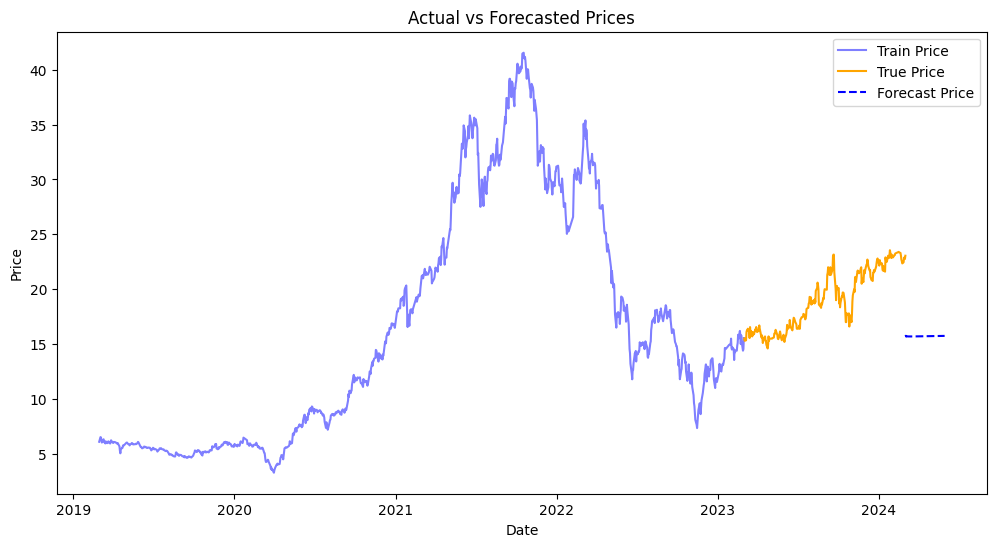

In [61]:
forecast_horizon = 90
next_90_days_forecast = model_fit.forecast(steps=forecast_horizon)

# Create a dataframe for the forecasted values
# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(next_90_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)
# Plot the forecasted values
plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)
plt.plot(test.index, test["Price"], label='True Price', color='orange')
plt.plot(forecast_df.index, forecast_df["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()